In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.cross_validation as cv # will be nested into model_selection
import sklearn.grid_search as gs
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('data/titanic_train.csv')
test = pd.read_csv('data/titanic_test.csv')

In [3]:
train[train.columns[[2,4,5,1]]].head()
# train.columns[[2,4,5,1]] => Index(['Pclass', 'Sex', 'Age', 'Survived'], dtype='object')
# .head() -> top 5 lines.

,Pclass,Sex,Age,Survived
0,3,male,22.0,0
1,1,female,38.0,1
2,3,female,26.0,1
3,1,female,35.0,1
4,3,male,35.0,0


In [4]:
data = train[['Sex', 'Age', 'Pclass', 'Survived']].copy()
data['Sex'] = data['Sex'] == 'female' # female:True male:False
# print(len(data)) #=> 891
# NaNを含む行を削除
data = data.dropna()
# print(len(data)) #=> 714

In [5]:
data_np = data.astype(np.int32).values
X = data_np[:, :-1] #属性情報（性別、年齢、乗客クラス）
Y = data_np[:, -1]  #ラベル情報（生存）

In [6]:
# we define a few boolean vectors.論理配列をいくつか定義する
female = X[:,0] == 1
survived = Y == 1
age = X[:,1]
# we compute a few histograms.
bins_ = np.arange(0, 81, 5)
S = {'male': np.histogram(age[survived & ~female],
                          bins=bins_)[0],
     'female': np.histogram(age[survived & female],
                            bins=bins_)[0]}
D = {'male': np.histogram(age[~survived & ~female],
                          bins=bins_)[0],
     'female': np.histogram(age[~survived & female],
                            bins=bins_)[0]}
# bins_ #=> array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
# bins_[:-1] #=> array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])

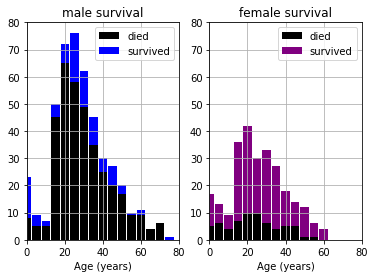

In [7]:
# we now plot the data.
bins = bins_[:-1]
width=4.5
for i, sex, color in zip((0,1),
                         ('male', 'female'),
                         ('blue', 'purple')):
    plt.subplot( 121 + i )
    plt.bar(bins, D[sex],
            color='k', width=width, label='died')
    plt.bar(bins, S[sex], bottom=D[sex],
            color=color, width=width, label='survived')
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.grid(None)
    plt.title(sex+' survival')
    plt.xlabel('Age (years)')
    plt.legend()


In [8]:
# 性別、年齢、船室等級で乗客が生存したかを予測するために、LogisticRegression 分類器を訓練する
# we split X and Y into train and test datasets.
(X_train, X_test, Y_train, Y_test) = cv.train_test_split(X, Y, test_size=.05)

In [9]:
# we instanciate the classifier. 分類機をインスタンス化する
logreg = lm.LogisticRegression()

In [10]:
# train and predict
logreg.fit(X_train, Y_train)
Y_predicted = logreg.predict(X_test)

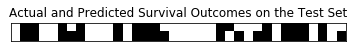

In [11]:
# compare prediction and actual result
plt.imshow(np.vstack((Y_test, Y_predicted)),
           interpolation='none', cmap='bone')
plt.xticks([]); plt.yticks([])
plt.title(('Actual and Predicted Survival '
           'Outcomes on the Test Set'))

In [12]:
# モデル性能を評価するために、cross_val_score() 関数で交差検証スコアを算出する。
# この関数 は、層化 3 分割交差検証を用いるが、cv キーワード引数で検定方法を指定できる。
cv.cross_val_score(logreg, X, Y)
# この関数は、訓練とテスト用データの組み合わせごとに、予測値
# (解説セクションで、詳しく説 明する)を返す。

array([ 0.78661088,  0.78991597,  0.78059072])

In [13]:
# LogisticRegression クラスは、C ハイパーパラメータを引数に持ち、
# このパラメータで正則化 の強さを指定する。
# 良い値を見つけるには、GridSearchCV クラスを用いてグリッドサーチを行う。
# 関数のパラメータとして、評価器とパラメータの値を収めた辞書を渡す。
# この評価器は 最良のパラメータを選択するために交差検証を行う。
grid = gs.GridSearchCV(logreg,
                       {'C': np.logspace(-5, 5, 50)})
grid.fit(X_train, Y_train)
grid.best_params_

{'C': 0.047148663634573942}

In [14]:
cv.cross_val_score(grid.best_estimator_, X, Y)

array([ 0.77405858,  0.79831933,  0.79324895])